<a href="https://colab.research.google.com/github/anxosanchez/cheel/blob/main/Maccabe_Thiele.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import matplotlib.pyplot as plt
import numpy as np

Definimos algúns parámetros de entrada. Fracción molar do compoñente lixeiro na alimentación ($x_F$), fracción molar desexada do compoñente lixeiro no destilado ($x_D$) e saída do reboiler ($x_W$), factor de separación ($a$) e condición de alimentación ($q$).

In [4]:
xF = 0.35  # Fracción molar de compoñente lixeiro na alimentación, -
xD = 0.975 # Fracción molar de compoñente lixeiro no destilado, -
xW = 0.025 # Fracción molar de compoñente lixeiro no reboiler, -
R  = 1.5   # Relación de refluxo (L/D), -
a  = 2.5   # Factor de separación
q  = 1.5   # Condición de alimentación1

A seguinte función, **eq_curve**, usa o factor de separación como entrada e devolve as fraccións molares de equilibrio do compoñente lixeiro en fases vapor e líquida. Aquí, implementáronse as ecuacións máis sinxelas para describir o equilibrio.
  
$$
y = \frac { \alpha x } { 1  + x ( \alpha - 1 ) } \tag{1}
$$
  
Volatilidade relativa, ecuación (1).

In [6]:
# Curva de  equilibrio 
def eq_curve(a):
    x_eq = np.linspace(0,1,51)
    y_eq = a*x_eq/(1+(a-1)*x_eq)
    return y_eq, x_eq
y_eq, x_eq = eq_curve(a)

$$
y = \frac { q } { q - 1 } x - \frac { x_F } { q - 1 } \tag{2}
$$
  
A continuación, imos igualar a ecuación 1 e a ecuación 2 e, posteriormente, reordenamos para obter a seguinte ecuación cuadrática.

Ecuación 3
A seguinte función (fed), primeiro calcula as raíces da ecuación 3 e escolle a raíz positiva (xiE). En segundo lugar, substitúe esta raíz positiva na ecuación 1 para producir a fracción molar de equilibrio correspondente da compoñente lixeira en fase de vapor (yiE). Teña en conta que, este é o punto (xiE, yiE) onde a liña de alimentación corta a curva de equilibrio. En terceiro lugar, devólvense x_fed e y_fed, os vectores que constitúen a liña de alimentación.

In [7]:
# recta de alimentación
def fed(xF,q,a):    
    c1 = (q*(a-1))
    c2 = q + xF*(1-a) - a*(q-1)
    c3 = -xF
    coeff = [c1, c2, c3]
    r = np.sort(np.roots(coeff))
    
    if r[0]>0:
        xiE = r[0]
    else:
        xiE = r[1]
   
    yiE = a*xiE/(1+ xiE*(a-1))
    if q == 1:
        x_fed = [xF, xF]
        y_fed = [xF, yiE]
    else:
        x_fed = np.linspace(xF, xiE, 51)
        y_fed = q/(q-1)*x_fed - xF/(q-1)
    
    return xiE, yiE, y_fed, x_fed
xiE, yiE, y_fed, x_fed = fed(xF,q,a)

In [8]:
# R_min r R (novow)
R_min = (xD-yiE)/(yiE-xiE)
R = R*R_min

In [10]:
# Punto de alimentación
xiF = (xF/(q-1)+xD/(R+1))/(q/(q-1)-R/(R+1))
yiF = R/(R+1)*xiF + xD/(R+1)
######## Rectifying section ########
def rect(R,xD,xiF):
    x_rect = np.linspace(xiF-0.025,xD,51)    
    y_rect = R/(R+1)*x_rect + xD/(R+1)
    return y_rect,x_rect
y_rect, x_rect = rect(R, xD,xiF)
######## Stripping section ########
def stp(xiF,yiF,xW):
    x_stp = np.linspace(xW,xiF+0.025,51)    
    y_stp = ((yiF-xW)/(xiF-xW))*(x_stp-xW) + xW
    return y_stp,x_stp
y_stp, x_stp = stp(xiF,yiF,xW)

In [12]:
# Construción das etapas
s = np.zeros((1000,5)) # array baleiro (s) para calculatar as coordinadas das etapas
for i in range(1,1000):
    # (s[i,0],s[i,1]) = (x1,y1) --> Primeiro punto
    # (s[i,2],s[i,3]) = (x2,y2) --> Segundo punto
    # Conéctase (x1,y1) e (x2,y2) para as etapas
    
    s[0,0] = xD
    s[0,1] = xD
    s[0,2] = s[0,1]/(a-s[0,1]*(a-1))
    s[0,3] = s[0,1]
    s[0,4] = 0
# x1
    s[i,0] = s[i-1,2]
    
    # Salto da primeira etapa (x1,y1) < (xW,xW)
    if s[i,0] < xW:
        s[i,1] = s[i,0] 
        s[i,2] = s[i,0]
        s[i,3] = s[i,0]
        s[i,4] = i
        break  
    
    # y1
    if s[i,0] > xiF:
        s[i,1] = R/(R+1)*s[i,0] + xD/(R+1)
    elif s[i,0] < xiF:
        s[i,1] = ((yiF-xW)/(xiF-xW))*(s[i,0]-xW) + xW
    else:
        s[i,1] = s[i-1,3]
    
    # x2
    if s[i,0] > xW:
        s[i,2] = s[i,1]/(a-s[i,1]*(a-1))
    else:
        s[i,2] = s[i,0]
    
    # y2
    s[i,3] = s[i,1]
    
    # No of stages
    if s[i,0] < xiF:
        s[i,4] = i
    else:
        s[i,4] = 0
s = s[~np.all(s == 0, axis=1)] # Borrando as celas que conteñen ceros  
#print(s)
S = np.zeros((s_rows*2,2)) # Rearraanxi do array 's' para a representación
for i in range(0,s_rows):
    S[i*2,0] = s[i,0]
    S[i*2,1] = s[i,1]
    S[i*2+1,0] = s[i,2]
    S[i*2+1,1] = s[i,3]

# Numeración das etapas
# (x2,y2) do array 's' como (x_s,y_s) usado para numerar as etaps
x_s = s[:,2:3]
y_s = s[:,3:4]
stage = np.char.mod('%d', np.linspace(1,s_rows-1,s_rows-1))

In [13]:
s_f = s_rows-np.count_nonzero(s[:,4:5], axis=0)
print(s_f)

[8]


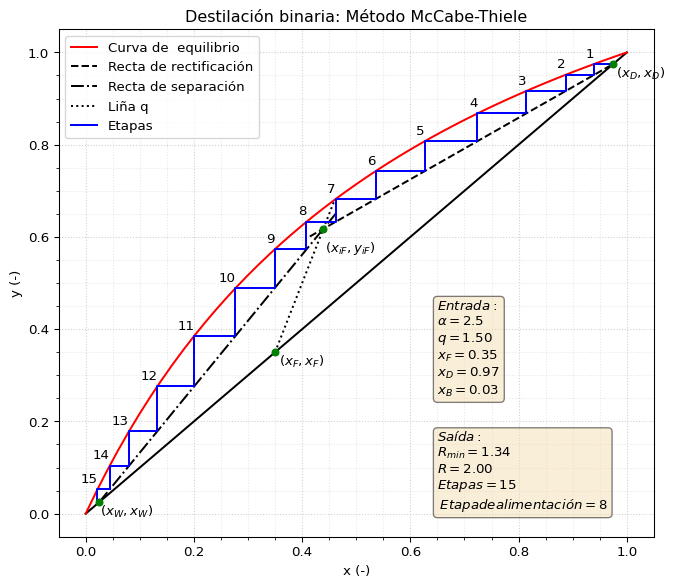

In [34]:
fig = plt.figure(num=None, figsize=(8, 7), dpi = 96)
# Liña de paridade
plt.plot([0,1],[0,1],"k-")

# Curva de  equilibrio
plt.plot(x_eq,y_eq,"r-", label="Curva de  equilibrio")

# Recta da sección de de rectificación
plt.plot(x_rect,y_rect,'k--', label="Recta de rectificación")

# Recta da sección de separación
plt.plot(x_stp,y_stp,'k-.', label="Recta de separación")

# Liña de alimentación
plt.plot(x_fed,y_fed,'k:', label="Liña q")

# Etapas
plt.plot(S[:,0],S[:,1],'b-', label="Etapas")

# Número das etapas
for label, x, y in zip(stage, x_s, y_s):
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(0,5),
                 textcoords='offset points', 
                 ha='right')
    
# Puntos de Alimentación destilado e Fervedor
plt.plot(xF,xF,'go',xD,xD,'go',xW,xW,'go',markersize=5)   
plt.text(xF+0.05,xF-0.03,'($x_{F}, x_{F}$)',horizontalalignment='center')
plt.text(xD+0.05,xD-0.03,'($x_{D}, x_{D}$)',horizontalalignment='center')
plt.text(xW+0.05,xW-0.03,'($x_{W}, x_{W}$)',horizontalalignment='center')
# Intersection: Rectifying + Stripping + Feedline
plt.plot(xiF,yiF,'go',markersize=5)
plt.text(xiF+0.05,yiF-0.05,'($x_{iF}, y_{iF}$)',horizontalalignment='center')
# Creamos caixas chulas
textstr1 = '\n'.join((
    r'$Entrada:$',
    r'$\alpha=%.1f$' % (a, ),
    r'$q=%.2f$' % (q, ),
    r'$x_F=%.2f$' % (xF, ),
    r'$x_D=%.2f$' % (xD, ),
    r'$x_B=%.2f$' % (xW, )))
textstr2 = '\n'.join((
    r'$Saída:$',
    r'$R_{min}=%.2f$' % (R_min, ),
    r'$R=%.2f$' % (R, ),
    r'$Etapas=%.0f$' % (s_rows-1, ),
    r'$\:Etapa de alimentación=%.0f$' % (s_f, )))
# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.65, 0.25, textstr1, fontsize=10, verticalalignment='bottom', bbox=props)
plt.text(0.65, 0.0, textstr2, fontsize=10, verticalalignment='bottom', bbox=props)  

# Xenal
plt.grid(b=True, which='major',linestyle=':',alpha=0.6)
plt.grid(b=True, which='minor',linestyle=':',alpha=0.3)
plt.minorticks_on()
plt.legend(loc="upper left")
plt.xlabel("x (-)")
plt.ylabel("y (-)")
plt.savefig('Metodo_McCabe_Thiele.jpeg', dpi=fig.dpi)
plt.title("Destilación binaria: Método McCabe-Thiele")
plt.show()